In [1]:
#Grab historical Sales data
#Seasonality Variables, Qtr, Period
#Event sku?
# Sku age
# CPI
%matplotlib inline

print(str(400000*60*720))

17280000000


In [4]:
import sys
sys.path.insert(0, r"C:\users\pairwin\Documents\Github\HelperPI")

import HelperPI
import seaborn as sbs
import pandas as pd
import scipy.stats as sts

In [5]:
helper = HelperPI.Helper()

INFO:root:Initializing...


In [9]:
sql = helper.getSQL(r"C:\users\pairwin\Documents\GitHub\IPy_Notebooks\SQL\TestSql.sql")

In [10]:
data, dtypedf = helper.readData(sql)

INFO:root:Reading data...
INFO:root:Data read complete...


             Count Column Type
0      FISCAL_YEAR       int64
1          REBUYER      object
2          FREQ_1X     float64
3      FREQ_2XPLUS     float64
4            TOTAL     float64
5       SPEND_0_25     float64
6      SPEND_26_50     float64
7     SPEND_51_100     float64
8    SPEND_101_250     float64
9   SPEND_251_PLUS     float64
10      D100BUYERS     float64
11      D151BUYERS     float64
12      D175BUYERS     float64
13      D200BUYERS     float64
14      D300BUYERS     float64
15      D350BUYERS     float64
16      D400BUYERS     float64
17      D450BUYERS     float64
18      D475BUYERS     float64
19      D500BUYERS     float64
20      D600BUYERS     float64
21      D650BUYERS     float64
22      D675BUYERS     float64
23      D700BUYERS     float64
24      D800BUYERS     float64
25      D850BUYERS     float64
26      D875BUYERS     float64
27      D999BUYERS     float64
28      BRANDEDYES     float64
29       BRANDEDNO     float64


In [11]:
data.head()

,FISCAL_YEAR,REBUYER,FREQ_1X,FREQ_2XPLUS,TOTAL,SPEND_0_25,SPEND_26_50,SPEND_51_100,SPEND_101_250,SPEND_251_PLUS,...,D600BUYERS,D650BUYERS,D675BUYERS,D700BUYERS,D800BUYERS,D850BUYERS,D875BUYERS,D999BUYERS,BRANDEDYES,BRANDEDNO
0,2016,A. YES DIR/RET,26963.0,29357.0,56320.0,3820.0,6982.0,11257.0,16571.0,17690.0,...,12521.0,3492.0,738.0,4197.0,216.0,1136.0,0.0,2651.0,38229.0,46640.0
1,2016,B. YES DIR ONLY,83394.0,62969.0,146363.0,13963.0,23426.0,34659.0,42062.0,32253.0,...,33045.0,10641.0,1799.0,10023.0,684.0,2699.0,1.0,8995.0,99313.0,113216.0
2,2016,C. YES RET ONLY,120729.0,39546.0,160275.0,18184.0,29960.0,41325.0,43520.0,27286.0,...,27454.0,8667.0,1655.0,10691.0,481.0,1900.0,0.0,6536.0,89633.0,117430.0
3,2016,D.NO,1096708.0,172958.0,1269666.0,220539.0,312328.0,351224.0,274359.0,111216.0,...,231923.0,84371.0,16622.0,94106.0,5538.0,13240.0,1.0,94318.0,689830.0,854219.0
4,2015,A. YES DIR/RET,32753.0,33173.0,65926.0,4463.0,8029.0,13963.0,19673.0,19798.0,...,13577.0,4007.0,703.0,5313.0,331.0,1411.0,0.0,3127.0,44474.0,54471.0


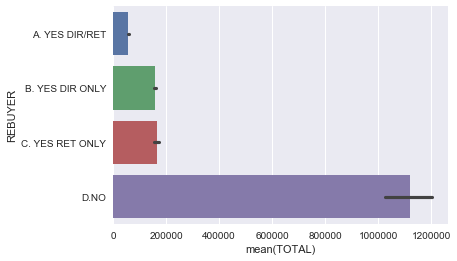

In [29]:
sbs.barplot(x="TOTAL", y="REBUYER", data=data)